### data: http://www.vision.caltech.edu/visipedia-data/CUB-200/images.tgz
### 挑选前6种鸟类做多标签分类实验，写个脚本删除其中"._"开头的文件

In [1]:
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [24]:
RAW_PATH = "E:/brid/raw_data" # 原始图像路径：6种（自己拷贝出来，
ROOT_PATH = "E:/brid/data/" # 数据增光之后新的图像路径

In [3]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

# 将数据按（10:3:3）划分为训练集、测试集、验证集
file_name = {'train':10, 'test':3, 'val':3}

# 自动将数据增光并划分到对应的集合中
for key,values in file_name.items():
    for i in os.listdir(RAW_PATH):
        os.makedirs(ROOT_PATH + str(key) + "/" + str(i))
        next_path = os.path.join(RAW_PATH, i)
        for j in os.listdir(next_path):
            img = load_img(next_path + "/" + j)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            q = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=ROOT_PATH + str(key) + "/" + str(i), 
                                      save_prefix='pandas', save_format='jpg'):
                q += 1
                if q > values:
                    break

#### 定义数据的路径

In [22]:
train_data = os.path.join(ROOT_PATH, 'train')
test_data = os.path.join(ROOT_PATH, 'test')
val_data = os.path.join(ROOT_PATH, 'val')

#### 模型训练的参数

In [11]:
nb_train_samples = 540
nb_validation_samples = 60
epochs = 40
batch_size = 20

In [25]:
model = Sequential()
model.add(Conv2D(32, 3, activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# 数据增强
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
# 测试数据不需要增强
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(val_data,
                                                        target_size=(150,150),
                                                        batch_size=32,
                                                        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(val_data,
                                                        target_size=(150,150),
                                                        batch_size=32,
                                                        class_mode='categorical')

Found 1891 images belonging to 6 classes.
Found 692 images belonging to 6 classes.
Found 692 images belonging to 6 classes.


In [15]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

Epoch 1/40
27/27 [==============================] - 8s 300ms/step - loss: 0.4513 - acc: 0.8324 - val_loss: 0.4234 - val_acc: 0.8403
Epoch 2/40
27/27 [==============================] - 6s 210ms/step - loss: 0.4248 - acc: 0.8399 - val_loss: 0.3689 - val_acc: 0.8559
Epoch 3/40
27/27 [==============================] - 6s 217ms/step - loss: 0.4247 - acc: 0.8391 - val_loss: 0.3991 - val_acc: 0.8472
Epoch 4/40
27/27 [==============================] - 6s 212ms/step - loss: 0.4082 - acc: 0.8420 - val_loss: 0.4153 - val_acc: 0.8385
Epoch 5/40
27/27 [==============================] - 6s 226ms/step - loss: 0.3878 - acc: 0.8453 - val_loss: 0.3873 - val_acc: 0.8472
Epoch 6/40
27/27 [==============================] - 6s 221ms/step - loss: 0.3783 - acc: 0.8474 - val_loss: 0.3355 - val_acc: 0.8594
Epoch 7/40
27/27 [==============================] - 7s 245ms/step - loss: 0.3611 - acc: 0.8540 - val_loss: 0.3383 - val_acc: 0.8576
Epoch 8/40
27/27 [==============================] - 7s 250ms/step - loss: 0.

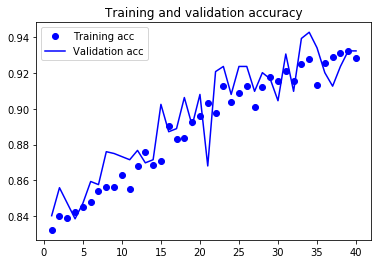

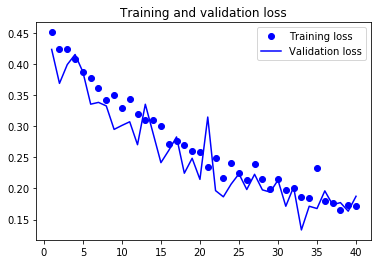

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show();

In [17]:
# 保存整个模型
model.save('model.hdf5')

# 保存模型的权重
model.save_weights('model_weights.h5')

# 保存模型的结构
json_string = model.to_json()
open('model_to_json.json','w').write(json_string)
yaml_string = model.to_yaml()
open('model_to_yaml.yaml','w').write(json_string)

3898

In [27]:
from keras.models import load_model
import numpy as np

model = load_model('model.hdf5')

img = load_img('E:/brid/raw_data/001/Black_footed_Albatross_0017_1256111444.jpg', target_size=(150, 150))
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)

predictions = model.predict(img)
predictions

array([[9.99885559e-01, 1.47223193e-06, 1.21112880e-08, 1.69357117e-09,
        1.13042945e-04, 1.08764009e-09]], dtype=float32)